<a href="https://colab.research.google.com/github/Vivian0105/Bioinformatics/blob/main/scRNAseq_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
# !pip install scanpy
# !pip install cupy-cuda11x
# !pip3 install igraph
# !pip install leidenalg

In [71]:
import warnings
warnings.simplefilter("ignore")
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata
import seaborn as sns
import os
import glob
import leidenalg

In [2]:
dir='drive/MyDrive/scRNAseq/'
samples=glob.glob(dir+'*.h5')

In [8]:
samples[:3]

['drive/MyDrive/scRNAseq/GSM4115880_SC68raw_feature_bc_matrix.h5',
 'drive/MyDrive/scRNAseq/GSM4115882_SC70raw_feature_bc_matrix.h5',
 'drive/MyDrive/scRNAseq/GSM4115881_SC69raw_feature_bc_matrix.h5']

In [9]:
meta=pd.read_csv(dir+'SraRunTable.csv')
meta.head(2)

,Run,Assay Type,AssemblyName,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,chemistry,...,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,tissue
0,SRR10254548,RNA-Seq,GCF_000001405.29,98,20294765414,PRJNA576702,SAMN13002514,8453401374,GEO,10X Genomics 3 Prime V1 chemistry,...,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2021-05-20T00:00:00Z,2019-10-09T18:19:00Z,1,GSM4115868,"dorsal\, mid-forearm skin biopsy",SRP224991,"skin,skin"
1,SRR10254549,RNA-Seq,GCF_000001405.29,98,26778655722,PRJNA576702,SAMN13002513,10356538606,GEO,10X Genomics 3 Prime V1 chemistry,...,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2021-05-20T00:00:00Z,2019-10-09T18:18:00Z,1,GSM4115869,"dorsal\, mid-forearm skin biopsy",SRP224991,"skin,skin"


In [11]:
# Read h5 files of each sample and concatenate the samples together
adatas = {}
for sample in samples:
    sample_name=sample.split('/')[-1]
    sample_name=sample_name[:10]
    sample_adata = sc.read_10x_h5(sample)
    sample_adata.var_names_make_unique()
    sample_adata.obs['tissue']='skin'
    sample_adata.obs['sample_name']=sample_name
    sample_adata.obs['condition']=meta[meta['Sample Name']==sample_name]['condition'].item()
    adatas[sample_name] = sample_adata
adata = anndata.concat(adatas)
adata.obs_names_make_unique()
adata

AnnData object with n_obs × n_vars = 16220160 × 33538
    obs: 'tissue', 'sample_name', 'condition'

In [12]:
adata.obs[['sample_name','condition']].drop_duplicates().condition.value_counts()

,count
condition,
SSC,12
CONTROL,10


In [13]:
adata.write(dir+'GSE138669_RAW.h5ad')

In [ ]:
# Now we have concatenated raw data of 22 patients with 16220160 cells and 33538 measured genes.

In [ ]:
# Data Preprocessing

In [3]:
adata=anndata.read_h5ad(dir+'GSE138669_RAW.h5ad')

In [4]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [5]:
# filtered cells with less than 100 genes expressed.
# filtered genes that are detected in less than 3 cells.
print('Before filtering, there are %i cells with %i measured genes'%(adata.n_obs, adata.n_vars))
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
print('After filtering, there are %i cells left with %i genes'%(adata.n_obs, adata.n_vars))

Before filtering, there are 16220160 cells with 33538 measured genes
After filtering, there are 108726 cells left with 25208 genes


In [6]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

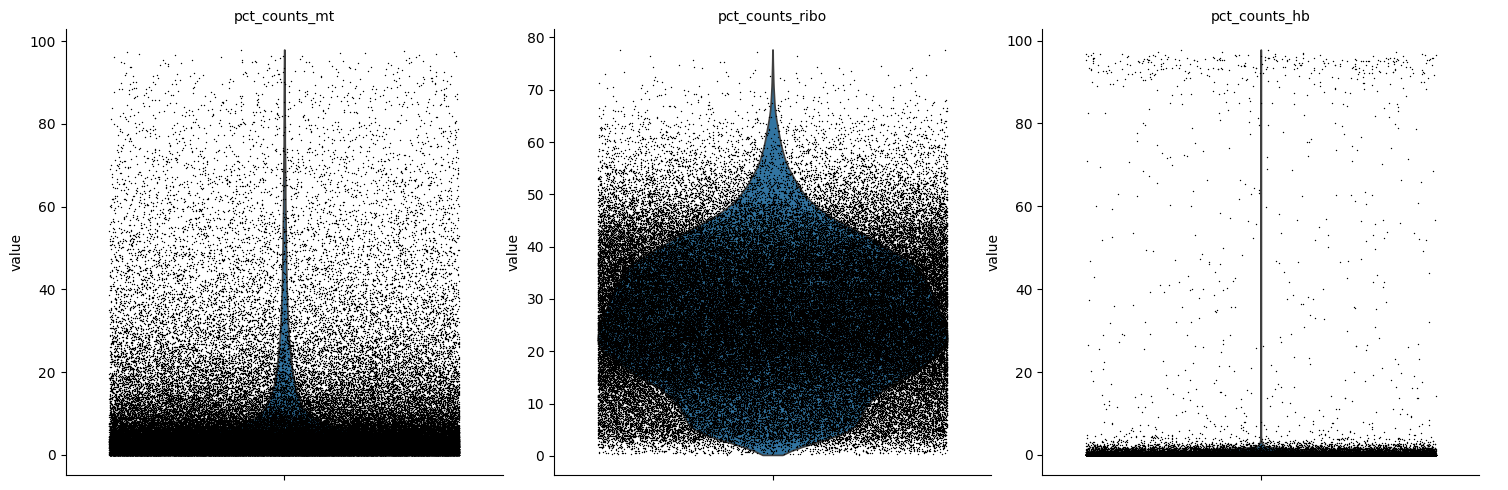

In [7]:
sc.pl.violin(
    adata,
    ["pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4,
    multi_panel=True,
)

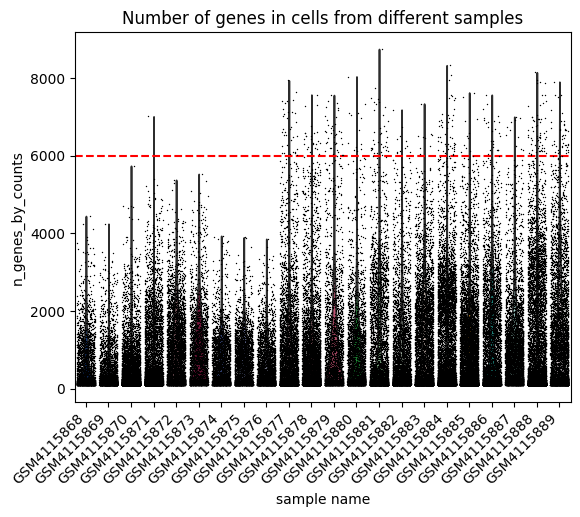

In [8]:
ax=plt.subplot()
sc.pl.violin(
    adata,
    ['n_genes_by_counts'],
    jitter=0.4,
    groupby='sample_name',
    ax=ax,
    show=False
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title("Number of genes in cells from different samples")
ax.axhline(y=6000, color='r', linestyle='--')
plt.show()

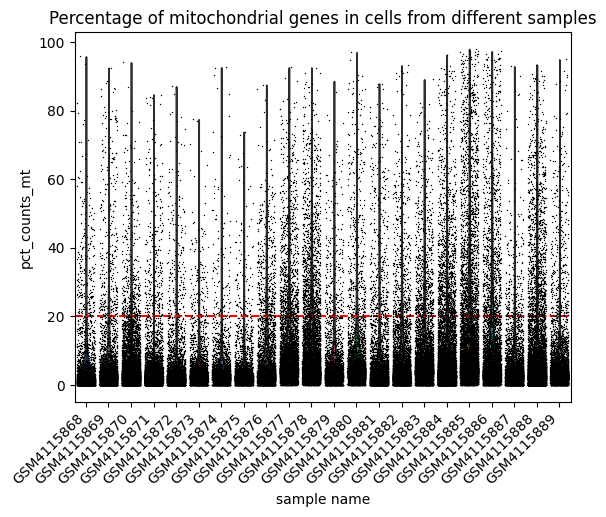

In [10]:
ax=plt.subplot()
sc.pl.violin(
    adata,
    ["pct_counts_mt"],
    jitter=0.4,
    groupby='sample_name',
    ax=ax,
    show=False
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title("Percentage of mitochondrial genes in cells from different samples")
ax.axhline(y=20, color='r', linestyle='--')
plt.show()

In [ ]:
# Filter out cells with more than 6000 genes and cells with more than 20% mitochondrial genes

In [11]:
print('Before filtering, there are %i cells'%adata.n_obs)
adata=adata[adata.obs['n_genes_by_counts']<6000]
adata=adata[adata.obs['pct_counts_mt']<20]
print('After filtering, there are %i cells left.'%adata.n_obs)

Before filtering, there are 108726 cells
After filtering, there are 96808 cells left.


In [12]:
adata.write(dir+"GSE138669_after_QC.h5ad")

In [ ]:
# Normalization and Dimension Reduction

In [49]:
adata=anndata.read_h5ad(dir+"GSE138669_after_QC.h5ad")

In [50]:
# Saving raw count
adata.layers["raw"] = adata.X.copy()

In [51]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [52]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [53]:
adata_sub = adata[:, adata.var.highly_variable]

In [33]:
adata_sub

View of AnnData object with n_obs × n_vars = 96808 × 2989
    obs: 'tissue', 'sample_name', 'condition', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'sample_name_colors', 'log1p', 'hvg'
    layers: 'raw'

In [54]:
# principal component analysis which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata_sub, svd_solver="arpack")

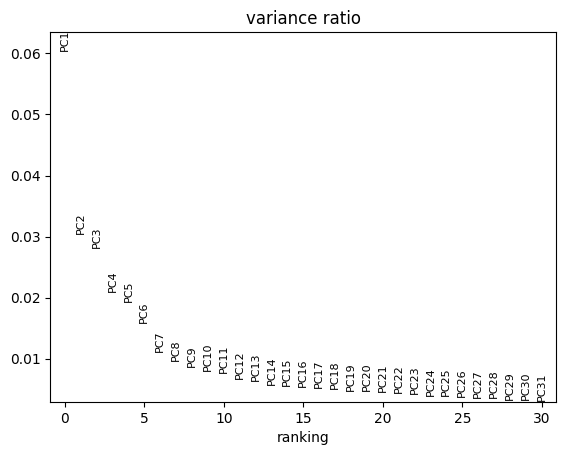

In [55]:
sc.pl.pca_variance_ratio(adata_sub, log=False)

In [59]:
sc.pp.neighbors(adata_sub, n_neighbors=20, n_pcs=30)

In [60]:
sc.tl.umap(adata_sub)

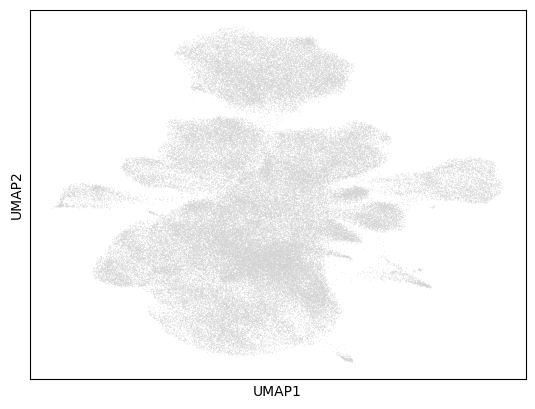

In [61]:
sc.pl.umap(adata_sub)

In [76]:
for res in [0.1, 0.5, 1.0]:
    sc.tl.leiden(
        adata_sub, key_added=f"leiden_res_{res:2.1f}", resolution=res, flavor="igraph"
    )

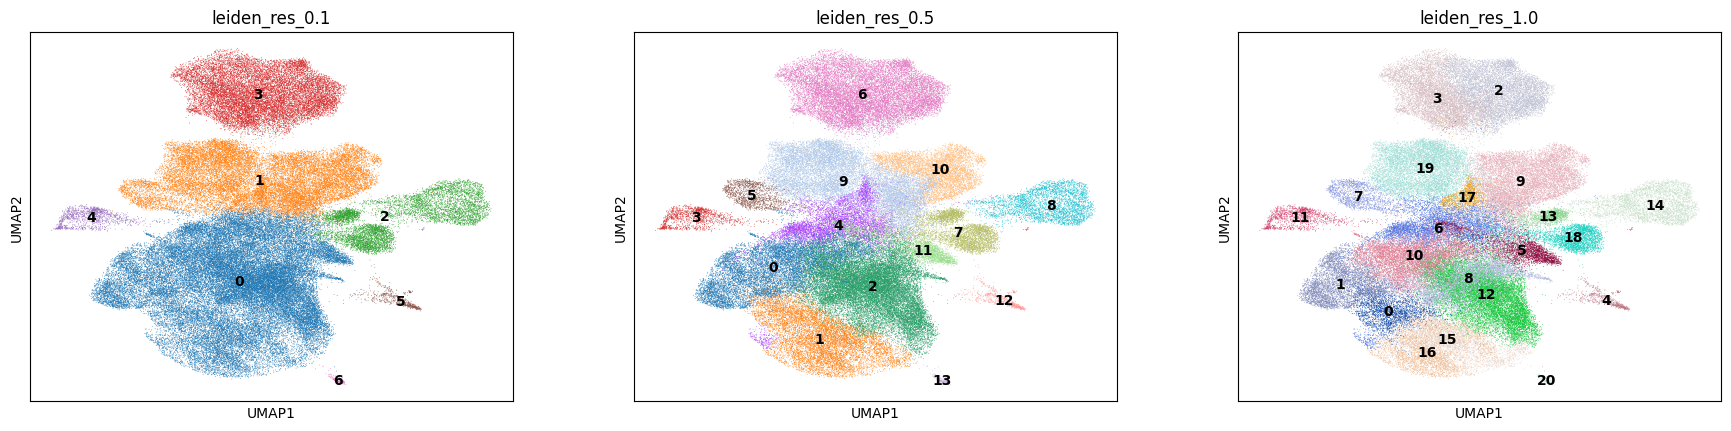

In [78]:
sc.pl.umap(
    adata_sub,
    color=["leiden_res_0.1", "leiden_res_0.5", "leiden_res_1.0"],
    legend_loc="on data",
)

In [79]:
adata_sub

AnnData object with n_obs × n_vars = 96808 × 2989
    obs: 'tissue', 'sample_name', 'condition', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'leiden', 'leiden_res_0.1', 'leiden_res_0.5', 'leiden_res_1.0'
    var: 'mt', 'ribo', 'hb', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'sample_name_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'leiden_res_0.1', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_0.1_colors', 'leiden_res_0.5_colors', 'le

In [81]:
adata.obs=adata_sub.obs
adata.uns=adata_sub.uns
adata.obsm=adata_sub.obsm
adata.obsp=adata_sub.obsp

In [83]:
adata.write(dir+'GSE138669_after_leiden.h5ad')

In [84]:
# Further analysis